# Comparison Example : scores

In this jupyter notebook we present the implementation of the gridness score as defined by by Sargolini et al 2006 https://pubmed.ncbi.nlm.nih.gov/16675704/. 

We conduct an autocorrelation analysis of the smoothed spatial rate map. From this analysis, we identified six peaks closest to the central peak and encompassed them within a ring, excluding the central peak. The purpose of this step was to examine the periodicity between these fields . Subsequently, we performed a rotational autocorrelation of this ring and observed the correlations' periodic patterns. To quantify the gridness, we computed a gridness score. This score was determined as the difference between the lowest correlation observed at 60 or 120 degrees of rotation and the highest correlation observed at 30, 90, or 150 degrees of rotation. The results of this analysis are presented as 'gridness measure 1

Generraly a score larger than [0.2] clasify as a grid cell.


 
The code was appadted from:

https://github.com/rhayman/ephysiopy/blob/12ee57a858161daa44546b75853a3333097ceb8a/ephysiopy/common/fieldcalcs.py#L743

We note that other measures have been developped to compute the gridness of a neural representation. We aim to implement a larger variety of score over time.



In [1]:
import sys
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from neuralplayground.arenas import Wernle2018, MergingRoom, Sargolini2006, Simple2D, BasicSargolini2006,Hafting2008
from neuralplayground.agents import Weber2018, Stachenfeld2018, RandomAgent, LevyFlightAgent
from neuralplayground.experiments import Wernle2018Data, Hafting2008Data, Sargolini2006Data
from neuralplayground.comparison import GridScorer


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## Experimental results 

We compute the gridness score for various experimental recordings 

###  Sargolini 

The get_scores function gives as out-put the spacial auto correlogram as well as various measures extracted from a spatial auto correlogram, including the grid score. 



[-4.92019210e+01 -4.72357276e+01 -4.52695343e+01 -4.33033410e+01
 -4.13371477e+01 -3.93709544e+01 -3.74047611e+01 -3.54385678e+01
 -3.34723745e+01 -3.15061812e+01 -2.95399879e+01 -2.75737946e+01
 -2.56076013e+01 -2.36414080e+01 -2.16752147e+01 -1.97090214e+01
 -1.77428280e+01 -1.57766347e+01 -1.38104414e+01 -1.18442481e+01
 -9.87805482e+00 -7.91186151e+00 -5.94566820e+00 -3.97947490e+00
 -2.01328159e+00 -4.70882839e-02  1.91910502e+00  3.88529833e+00
  5.85149164e+00  7.81768494e+00  9.78387825e+00  1.17500716e+01
  1.37162649e+01  1.56824582e+01  1.76486515e+01  1.96148448e+01
  2.15810381e+01  2.35472314e+01  2.55134247e+01  2.74796180e+01
  2.94458113e+01  3.14120046e+01  3.33781979e+01  3.53443912e+01
  3.73105845e+01  3.92767779e+01  4.12429712e+01  4.32091645e+01
  4.51753578e+01  4.71415511e+01  4.91077444e+01]
GridScorer_Sargo
(array([[        nan,  1.        ,  0.91699503, ...,  0.75538426,
         0.9999813 ,         nan],
       [ 1.        ,  0.27592835,  0.37914199, ..., 

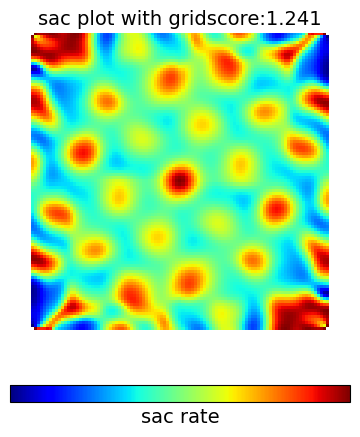

In [3]:
sargolini_data = Sargolini2006Data(verbose=False)
env = Sargolini2006(time_step_size=1,
                         agent_step_size=None)

# Change the recording_index=1 to see differernt celss
r_out_im,x_bin, y_bin = env.recording_tetr(recording_index=2)
print(x_bin)
GridScorer_Sargolini2006 = GridScorer(x_bin)
GridScorer_Sargolini2006.plot_grid_score(r_out_im=r_out_im, plot= True)
score = GridScorer_Sargolini2006 .get_scores(r_out_im)

print('GridScorer_Sargo')
print(score)


###  Hafting


[-15.657206   -14.08636685 -12.51552769 -10.94468854  -9.37384938
  -7.80301023  -6.23217107  -4.66133192  -3.09049276  -1.51965361
   0.05118555   1.6220247    3.19286386   4.76370301   6.33454217
   7.90538132   9.47622048  11.04705963  12.61789879  14.18873794
  15.7595771 ]
(array([[        nan, -1.00000001, -0.94876764, ..., -0.97900319,
        -1.        ,         nan],
       [-1.        , -0.92677731, -0.87850007, ..., -0.71520642,
        -0.88324372, -1.        ],
       [-0.96455092, -0.94696708, -0.9073003 , ..., -0.7563402 ,
        -0.87179014, -0.91008091],
       ...,
       [-0.91008091, -0.87179014, -0.7563402 , ..., -0.9073003 ,
        -0.94696708, -0.96455092],
       [-1.        , -0.88324372, -0.71520642, ..., -0.87850007,
        -0.92677731, -1.        ],
       [        nan, -1.        , -0.97900319, ..., -0.94876764,
        -1.00000001,         nan]]), {'gridscore': -0.14798879772341955, 'scale': 65.50829463212105, 'orientation': -0.0, 'closest_peak_coords'

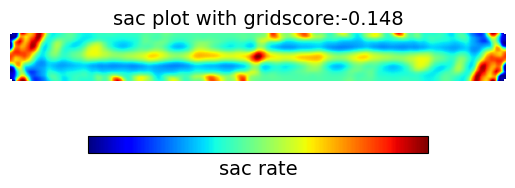

In [4]:
hafting_data = Hafting2008Data(verbose=False)
env = Hafting2008(time_step_size=1,
                         agent_step_size=None)
r_out_im,x_bin, y_bin = env.recording_tetr(recording_index=6)
print(y_bin)
GridScorer_Hafting2008 = GridScorer(x_bin )
GridScorer_Hafting2008.plot_grid_score(r_out_im=r_out_im, plot= True)
score = GridScorer_Hafting2008.get_scores(r_out_im)
print(score)

The plot_sac function returns a plot of the auto correlogram.

### Wernle

Subset of dataset wernle_2018 not available. Downloading the full dataset instead.
GridScorer_SR
(array([[        nan, -1.00000001, -0.94876764, ..., -0.97900319,
        -1.        ,         nan],
       [-1.        , -0.92677731, -0.87850007, ..., -0.71520642,
        -0.88324372, -1.        ],
       [-0.96455092, -0.94696708, -0.9073003 , ..., -0.7563402 ,
        -0.87179014, -0.91008091],
       ...,
       [-0.91008091, -0.87179014, -0.7563402 , ..., -0.9073003 ,
        -0.94696708, -0.96455092],
       [-1.        , -0.88324372, -0.71520642, ..., -0.87850007,
        -0.92677731, -1.        ],
       [        nan, -1.        , -0.97900319, ..., -0.94876764,
        -1.00000001,         nan]]), {'gridscore': -0.14798879772341955, 'scale': 65.50829463212105, 'orientation': -0.0, 'closest_peak_coords': array([[  1, 236],
       [ 18, 152],
       [ 20, 246],
       [ 20, 283],
       [ 18, 115],
       [ 38,  86]]), 'dist_to_centre': array([[False, False, False, ..., False, False

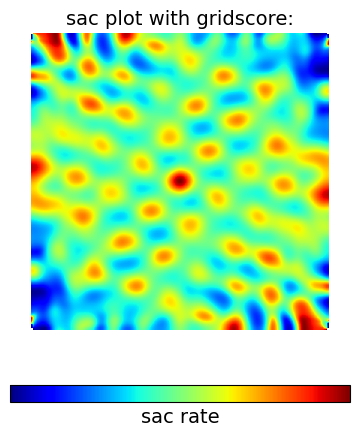

In [5]:
wernle_data =  Wernle2018Data()
h, x_bin, y_bin = wernle_data.recording_tetr()
r_out_im = h.reshape((x_bin.size, y_bin.size))
GridScorer_Wernle = GridScorer(x_bin.size-1)
score_Wernle = GridScorer_Wernle.get_scores(r_out_im)
GridScorer_Wernle.plot_sac(score_Wernle[0])
print('GridScorer_SR')
print(score)


Subset of dataset wernle_2018 not available. Downloading the full dataset instead.


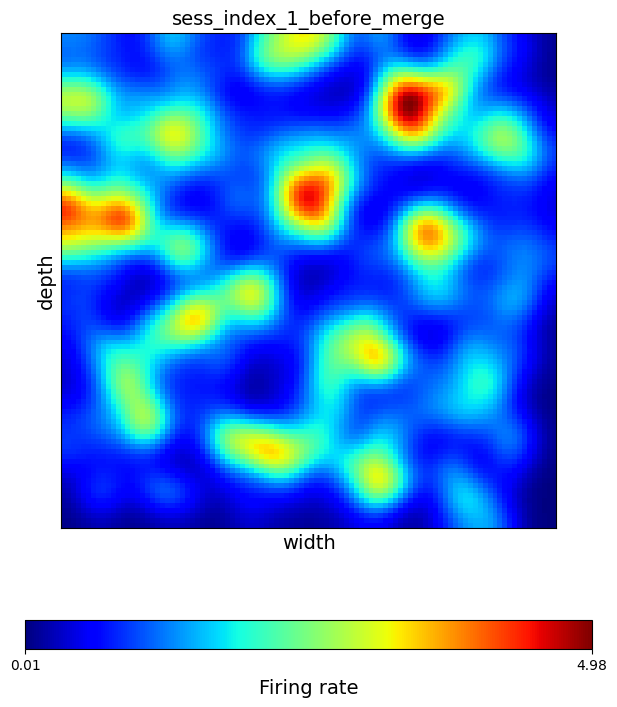

In [6]:
env = Wernle2018(time_step_size=1,
                         agent_step_size=None)
ax = env.plot_recording_tetr(recording_index=40)

In [7]:
print('GridScorer_SR')
print(score_Wernle[1])

GridScorer_SR
{'gridscore': 0.7909881908447487, 'scale': 27.586228448267445, 'orientation': -0.0, 'closest_peak_coords': array([[110, 124],
       [ 88,  74],
       [119,  80],
       [ 79, 118],
       [ 70,  92],
       [128, 106]]), 'dist_to_centre': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'ellipse_axes': (37.406864475114986, 33.12701923294519), 'ellipse_angle': 0.17848714501650464, 'ellipseXY': array([[ 36.81259705,   6.64125049],
       [ 35.75826906,  10.75561652],
       [ 34.11679128,  14.69337562],
       [ 31.91511672,  18.38986991],
       [ 29.18939684,  21.78440303],
       [ 25.98438786,  24.82123687],
       [ 22.35271596,  27.45050667],
       [ 18.35401307,  29.62

## Agents results 

We compute the gridness score for various Agents output recordings 

### Weber

100%|██████████████████████████| 4900/4900 [00:02<00:00, 2407.75it/s]


  0%|          | 0/4000 [00:00<?, ?it/s]

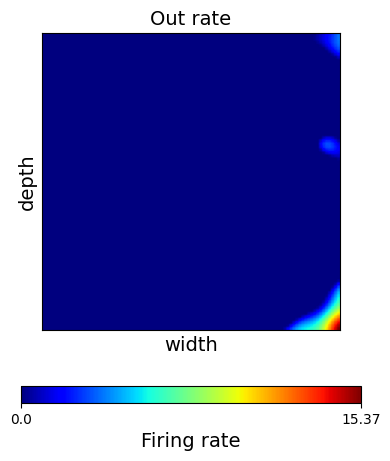

In [8]:
# Parameters for a square environment
room_width = [-10,10]
room_depth = [-10,10]
env_name = "env_example"
time_step_size = 1
agent_step_size = 0.5

# Init environment
envsimple = Simple2D(arena_x_limits = room_width,
                     arena_y_limits = room_depth,
                     time_step_size = time_step_size,
                     agent_step_size = agent_step_size)

exc_eta = 2e-4
inh_eta = 8e-4
model_name = "model_example"
sigma_exc = np.array([0.05, 0.05])
sigma_inh = np.array([0.1, 0.1])
Ne = 4900
Ni = 1225
Nef = 1
Nif = 1
alpha_i = 1
alpha_e = 1
we_init = 1.0
wi_init = 1.5
agent_step_size = 0.1
roh = 1
agent_Webber = Weber2018(model_name=model_name, exc_eta=exc_eta, inh_eta=inh_eta, sigma_exc=sigma_exc,
                  sigma_inh=sigma_inh, Ne=Ne, Ni=Ni, agent_step_size=agent_step_size, ro=roh,
                  Nef=Nef, Nif=Nif, room_width=envsimple.room_width, room_depth=envsimple.room_depth,
                  alpha_i=alpha_i, alpha_e=alpha_e, we_init=we_init, wi_init=wi_init)

plot_every = 100000  
total_iters = 0
n_steps = 4000
obs, state = envsimple.reset()
for i in tqdm(range(n_steps)):
    # Observe to choose an action, the first to numbers in the observation are the xy position of the agent
    obs = obs[:2]
    action = agent_Webber.act(obs)
    # rate = agent.update()
    agent_Webber.update()
    # Run environment for given action
    obs, state, reward = envsimple.step(action, normalize_step=True)
    total_iters += 1
    if i % plot_every == 0:
        agent_Webber.plot_rate_map()


GridScorer_Webber
(array([[        nan, -1.        , -0.9199498 , ...,         nan,
                nan,         nan],
       [-1.        , -0.76765038, -0.71957602, ...,         nan,
                nan,         nan],
       [-0.89092453, -0.65395917, -0.60598594, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ..., -0.60598594,
        -0.65395917, -0.89092453],
       [        nan,         nan,         nan, ..., -0.71957602,
        -0.76765038, -1.        ],
       [        nan,         nan,         nan, ..., -0.9199498 ,
        -1.        ,         nan]]), {'gridscore': -0.3249536533737541, 'scale': 37.656340767525464, 'orientation': -0.0, 'closest_peak_coords': array([[ 97, 134],
       [101,  64],
       [ 92,  62],
       [106, 136],
       [ 97,  40],
       [101, 158]]), 'dist_to_centre': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False

/Users/clementine/Documents/UCL/NeuralPlayground/neuralplayground/comparison/metrics.py:122: RuntimeWarning: invalid value encountered in divide
  A = np.squeeze(mapCovar / mapStd / mapStd[::-1, :, :][:, ::-1, :][:, :, :])


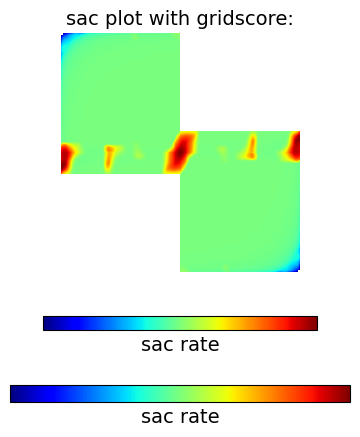

In [9]:
print('GridScorer_Webber')

r_out_im = agent_Webber.get_rate_map_matrix()
GridScorer_Weber2018 = GridScorer(agent_Webber.resolution_width)
GridScorer_Weber2018.plot_grid_score(r_out_im=r_out_im, plot= True)
score = GridScorer_Weber2018.get_scores(r_out_im)
GridScorer_Weber2018.plot_sac(score[0])
print(score)

### Stachenfeld

In [10]:
agent_step_size = 1
discount = .9
threshold = 1e-6
lr_td = 1e-2
t_episode = 10000
n_episode = 10000
state_density = (1 / agent_step_size)
twoDvalue = True

agent_SR = Stachenfeld2018(discount=discount, t_episode=t_episode, n_episode=n_episode, threshold=threshold, lr_td=lr_td,
               room_width=envsimple.room_width, room_depth=envsimple.room_depth, state_density=state_density, twoD=twoDvalue)

print('GridScorer_SR')
r_out_im=agent_SR.get_rate_map_matrix(eigen_vector=30)

GridScorer_ Stachenfeld2018 = GridScorer(agent_SR.resolution_width)
GridScorer_ Stachenfeld2018.plot_grid_score(r_out_im=r_out_im, plot= True)
score = GridScorer_Stachenfeld2018.get_scores(r_out_im)

print(score)

SyntaxError: invalid syntax (1269727096.py, line 16)

### Whittington

In [ ]:
import importlib
import os
import pickle
import pandas as pd
import torch
import matplotlib.pyplot as plt
import neuralplayground.agents.whittington_2020_extras.whittington_2020_analyse as analyse
from neuralplayground.plotting import PlotSim

In [ ]:
simulation_id = "TEM_custom_plot_sim"
from neuralplayground.saved_models import fetch_model_path
# save_path = fetch_model_path("tem_in_2D")
save_path= 'results_sim/'
plotting_loop_params = {"n_episode": 5000}

In [ ]:
training_dict = pd.read_pickle(os.path.join(os.getcwd(), save_path, "params.dict"))
model_weights = pd.read_pickle(os.path.join(save_path, "agent"))
model_spec = importlib.util.spec_from_file_location("model", save_path + "whittington_2020_model.py")
model = importlib.util.module_from_spec(model_spec)
model_spec.loader.exec_module(model)
params = pd.read_pickle(os.path.join(save_path, "agent_hyper"))
tem = model.Model(params)
tem.load_state_dict(model_weights)
tem.eval()

In [ ]:
sim = PlotSim(
    simulation_id=simulation_id,
    agent_class=training_dict["agent_class"],
    agent_params=training_dict["agent_params"],
    env_class=training_dict["env_class"],
    env_params=training_dict["env_params"],
    plotting_loop_params=plotting_loop_params,
)

In [ ]:
trained_agent, trained_env = sim.plot_sim(save_path, n_walks=1000, random_state=False, custom_state=[0.5,0.5])

In [ ]:
with open(os.path.join(save_path, "NPG_environments.pkl"), "rb") as f:
    environments = pickle.load(f)
with open(os.path.join(save_path, "NPG_model_input.pkl"), "rb") as f:
    model_input = pickle.load(f)

training_dict["params"] = training_dict["agent_params"]
del training_dict["agent_params"]
agent = training_dict["agent_class"](**training_dict["params"])
agent.plot_run(tem, model_input, environments)
agent.plot_rate_map(rate_map_type='g');
agent.plot_rate_map(rate_map_type='p');
rate_map_mat = agent.get_rate_map_matrix(agent.g_rates,1,2)
GridScorer = GridScorer(rate_map_mat.shape[0])
GridScorer.plot_grid_score(r_out_im = rate_map_mat, plot= True)
score = GridScorer.get_scores(rate_map_mat)